### Showcasing the power of Image Embeddings with CLIP

In [2]:
# Install all proper dependencies
# --- 🍀 Step 1: Install CLIP and dependencies safely ---
!pip install --upgrade --quiet pip setuptools wheel

# Install dependents individually to avoid version mismatch
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install --quiet ftfy regex tqdm matplotlib scikit-learn Pillow

# Use the official OpenAI CLIP repo (works with Python 3.10+)
!pip install --quiet git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 84.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch
import torchvision.transforms as transforms
import clip
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tqdm import tqdm
import os

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 216MiB/s]


In [5]:
image_paths = [
    "/content/add a hat to this young man.png",
    "/content/headshot.jpg"
]

# Step 3: Preprocess and embed
images = [preprocess(Image.open(p)).unsqueeze(0).to(device) for p in image_paths]

with torch.no_grad():
    features = [model.encode_image(img) for img in images]

# Step 4: Normalize the embeddings (important for cosine similarity)
features = [f / f.norm(dim=-1, keepdim=True) for f in features]

# Step 5: Display info
for path, feat in zip(image_paths, features):
    print(f"✅ {path}:")
    print("Shape:", feat.shape, " |  First 8 values:", feat[0, :8].cpu().numpy())
    print()

# (Optional) Compute similarity between the two embeddings
similarity = (features[0] @ features[1].T).item()
print(f"Cosine similarity between images: {similarity:.4f}")

✅ /content/add a hat to this young man.png:
Shape: torch.Size([1, 512])  |  First 8 values: [ 0.03632  0.01289 -0.0263  -0.01782  0.06226 -0.06396  0.02354  0.066  ]

✅ /content/headshot.jpg:
Shape: torch.Size([1, 512])  |  First 8 values: [ 0.04514  -0.000846  0.005585 -0.008575  0.0642   -0.04797   0.002445
  0.05692 ]

Cosine similarity between images: 0.8584


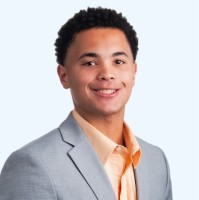

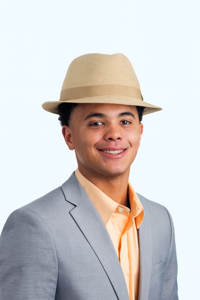

In [26]:
from PIL import Image
from IPython.display import display

image_paths = [
    '/content/headshot.jpg',
    '/content/add a hat to this young man.png'
]

for path in image_paths:
    img = Image.open(path)
    img.thumbnail((200, 300))  # Cap size to 150×150 pixels
    display(img)

In [57]:
from torch.nn import functional as F
import torch
from PIL import Image
import clip

# Set both image paths
img_with_hat_path = "/content/add a hat to this young man.png"
img_without_hat_path = "/content/headshot.jpg"

# Load and embed each image
with torch.no_grad():
    img_with_hat = preprocess(Image.open(img_with_hat_path)).unsqueeze(0).to(device)
    img_without_hat = preprocess(Image.open(img_without_hat_path)).unsqueeze(0).to(device)

    e_with_hat = model.encode_image(img_with_hat)
    e_without_hat = model.encode_image(img_without_hat)

# Normalize the embeddings
e_with_hat /= e_with_hat.norm(dim=-1, keepdim=True)
e_without_hat /= e_without_hat.norm(dim=-1, keepdim=True)

# Show the difference in expected valyes
diff = (e_with_hat - e_without_hat)
diff /= diff.norm(dim=-1, keepdim=True)

# Set potential labels
candidate_words = ["hat", "cap", "helmet", "hair", "head", "face", "smile",
    "shirt", "man", "glasses", "hood", "hoodie"]

# Encode text embeddings
text_tokens = clip.tokenize(candidate_words).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute the cosine similairty of the vectors
similarity = F.cosine_similarity(diff, text_features)  # 1 × N vector
similarity = similarity.cpu().numpy().flatten()

# Rank the canidate words and their probabilites based on embeddings
ranked = sorted(zip(candidate_words, similarity), key=lambda x: x[1], reverse=True)

# Display results
for word, score in ranked[:5]:
    print(f"{word:10s}  →  similarity: {score:.4f}")

hat         →  similarity: 0.1174
helmet      →  similarity: 0.0432
cap         →  similarity: 0.0351
hood        →  similarity: 0.0136
smile       →  similarity: 0.0027


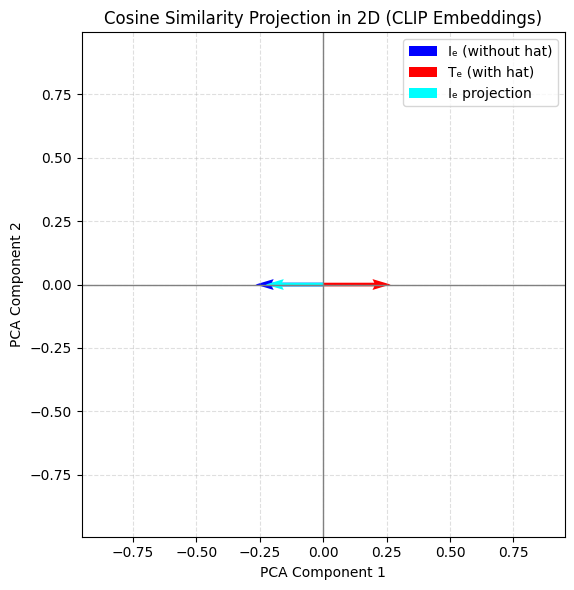

In [63]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch

# Convert embeddings to numpy
Ie = e_without_hat.cpu().numpy().flatten()   # without hat
Te = e_with_hat.cpu().numpy().flatten()      # with hat

# Reduce to 2D with PCA
pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(np.vstack([Ie, Te]))
Ie_2d, Te_2d = vecs_2d[0], vecs_2d[1]

# Compute projection of Ie onto Te (in 2D)
proj_len = np.dot(Ie_2d, Te_2d) / np.linalg.norm(Te_2d)
proj_dir = Te_2d / np.linalg.norm(Te_2d)
proj_vec = proj_len * proj_dir

# Shorter version for visibility (optional)
proj_vec_short = proj_vec * 0.85

# Create 2D plot
plt.figure(figsize=(6, 6))

# Draw origin lines
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)

# Draw arrows
plt.quiver(0, 0, *Ie_2d, angles='xy', scale_units='xy', scale=1, color='blue', label='Iₑ (without hat)')
plt.quiver(0, 0, *Te_2d, angles='xy', scale_units='xy', scale=1, color='red', label='Tₑ (with hat)')
plt.quiver(0, 0, *proj_vec_short, angles='xy', scale_units='xy', scale=1, color='cyan', label='Iₑ projection')


# Set equal aspect and limits
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.title('Cosine Similarity Projection in 2D (CLIP Embeddings)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()